###  MicroGrad demo (based on [karpathy/micrograd/demo.ipynb](https://github.com/karpathy/micrograd/blob/master/demo.ipynb))

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#from micrograd.engine import Value
#from micrograd.nn import Neuron, Layer, MLP
from littlegrad3.engine import Tensor

In [3]:
np.random.seed(1337)
random.seed(1337)

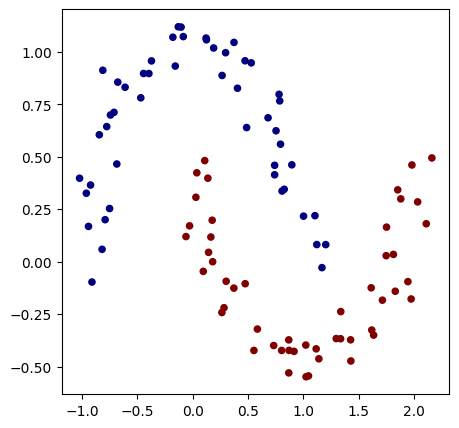

In [4]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [5]:
# initialize a model 
#model = MLP(2, [16, 16, 1]) # 2-layer neural network
#print(model)
#print("number of parameters", len(model.parameters()))

class LinearNet:
  def __init__(self):
    self.params = {
      'w1' : Tensor(2 * np.random.random_sample((2, 16)) - 1),
      'b1' : Tensor(np.zeros((1, 16))),
      'w2' : Tensor(2 * np.random.random_sample((16, 16)) - 1),
      'b2' : Tensor(np.zeros((1, 16))),
      'w3' : Tensor(2 * np.random.random_sample((16, 1)) - 1),
      'b3' : Tensor(np.zeros((1, 1)))
    }

  def parameters(self):
    return self.params.values()
  
  def zero_grad(self):
    for param in self.params.values():
        param.grad *= 0

  def __call__(self, x:Tensor) -> Tensor:
    return ((x@self.params['w1']+self.params['b1']).relu()@self.params['w2']+self.params['b2']).relu()@self.params['w3']+self.params['b3']
  
model = LinearNet()

TypeError: Tensor.__init__() takes 1 positional argument but 2 were given

In [ ]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    #inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    #scores = list(map(model, inputs))
    scores = list(map(model, [Tensor(xi) for xi in Xb]))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p.flatten()@p.flatten().transpose() for p in model.parameters()))
    total_loss = data_loss + reg_loss
    #total_loss = sum(losses) * (1.0 / len(losses))
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Tensor object with data [[1.58106339]] [[0.48]]


In [ ]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    #model.zero_grad()
    #total_loss.backward()
    total_loss.backprop()
    
    # update (sgd)
    #learning_rate = 1.0 - 0.9*k/100
    learning_rate = 0.01
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss [[1.58106339]], accuracy [[48.]]%
step 1 loss [[1.49365484]], accuracy [[48.]]%
step 2 loss [[1.32389669]], accuracy [[48.]]%
step 3 loss [[1.0820986]], accuracy [[51.]]%
step 4 loss [[0.81936741]], accuracy [[66.]]%
step 5 loss [[0.58329299]], accuracy [[83.]]%
step 6 loss [[0.45040592]], accuracy [[84.]]%
step 7 loss [[0.49154438]], accuracy [[78.]]%
step 8 loss [[0.52817831]], accuracy [[79.]]%
step 9 loss [[0.55052864]], accuracy [[78.]]%
step 10 loss [[0.55705064]], accuracy [[79.]]%
step 11 loss [[0.54946867]], accuracy [[79.]]%
step 12 loss [[0.53288765]], accuracy [[80.]]%
step 13 loss [[0.50456675]], accuracy [[81.]]%
step 14 loss [[0.47149769]], accuracy [[81.]]%
step 15 loss [[0.4405634]], accuracy [[84.]]%
step 16 loss [[0.41853935]], accuracy [[85.]]%
step 17 loss [[0.39458938]], accuracy [[85.]]%
step 18 loss [[0.37767741]], accuracy [[86.]]%
step 19 loss [[0.36258389]], accuracy [[87.]]%
step 20 loss [[0.34922364]], accuracy [[86.]]%
step 21 loss [[0.33515247

(-1.548639298268643, 1.951360701731357)

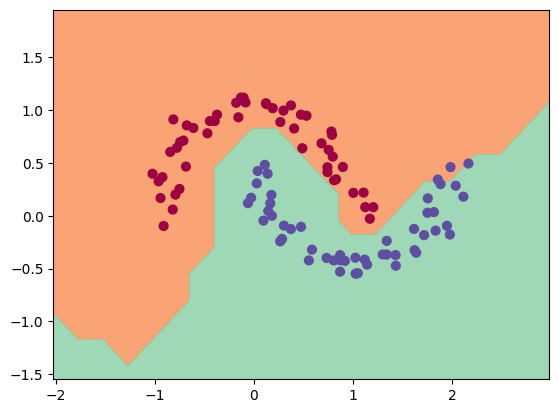

In [ ]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
#inputs = [list(map(Value, xrow)) for xrow in Xmesh]
#scores = list(map(model, inputs))
scores = list(map(model, [Tensor(xi) for xi in Xmesh]))

Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())


---

In [9]:
import cupy as cp
import numpy as np
import math
import sys
import time

from littlegrad3.engine import Tensor

In [19]:
test = cp.array(0.0)
print(test)
print(isinstance(test, cp.ndarray))
print(test.ndim)

cp.reshape(test, (1, 1))
test.reshape(1, 1)
print(test)
print(test.ndim)
print(test.reshape(1, 1).ndim)

0.0
True
0
0.0
0
2


In [ ]:
test = cp.arange(0, 6).reshape(2, 3)
print(test[1][1])
print(cp.array(test)[1][1])


4
4
5e-324


In [38]:
print(cp.log(0.1))
print(cp.log((1 == 1) * 1e-20))
print(cp.log(math.ulp(0.0)))
print(math.ulp(0.0))
print(sys.float_info.min)

-2.3025850929940455
-46.051701859880914
-744.4400719213812
5e-324
2.2250738585072014e-308


In [2]:
test = cp.arange(6).reshape(2, 3)
test2 = cp.zeros_like(test)
test3 = test * -1
print(test)
print(test2)
print(test3)

start = time.time()
print(cp.any(test), cp.any(test2), cp.any(test3))
end = time.time()
print(end-start)

start = time.time()
print(test == 0, test2 == 0, test3 == 0)
end = time.time()
print(end-start)

[[0 1 2]
 [3 4 5]]
[[0 0 0]
 [0 0 0]]
[[ 0 -1 -2]
 [-3 -4 -5]]
True False True
0.02656865119934082
[[ True False False]
 [False False False]] [[ True  True  True]
 [ True  True  True]] [[ True False False]
 [False False False]]
0.05948662757873535


In [ ]:
test = cp.arange(6).reshape(2, 3)
test2 = test + 1
test3 = cp.zeros_like(test)

print(test)
print(test2)

s = time.time()
print(cp.log(test + ((test == 0) * math.ulp(0.0))))

[[0 1 2]
 [3 4 5]]
[[1 2 3]
 [4 5 6]]


In [47]:
print(np.array(2)/np.array(3))
print(cp.array(2)/cp.array(3))
print(np.array(2)/np.array(3) == cp.array(2)/cp.array(3))


print(np.array(2.)*np.array(3.)**-1)
#print((np.array(2.)*np.array(3.)**-1) == (np.array(2)/np.array(3)))
print(cp.array(2.)*cp.array(3.)**-1)
#print((cp.array(2.)*cp.array(3.)**-1) == (cp.array(2)/cp.array(3)))
print((np.array(2.)*np.array(3.)**-1) == (cp.array(2.)*cp.array(3.)**-1))
print((np.array(3.)**-1) == (cp.array(3.)**-1))
print('poop')
print((cp.array(1.)/3) == (cp.array(3.)**-1))
print((cp.array(1.)/3) == (cp.array(1.0/3.0)))
print((cp.array(1.0)/3) == (cp.array(3.0)**-1.0))
print((cp.array(3.0**-1.0)) - cp.array(3.0)**-1.0)
print((1.0/3.0) == cp.array(3.0**-1.0))
print()
print((Tensor(1)/3).data[0][0] == (cp.array(3.)**-1))
print((Tensor(2)/Tensor(3)).data)
print((Tensor(2)/Tensor(3)).data - cp.array(2)/cp.array(3))
print((Tensor(2)/Tensor(3)).data - cp.array(2.)*cp.array(3.)**-1)

0.6666666666666666
0.6666666666666666
True
0.6666666666666666
0.6666666666666667
False
False
poop
False
True
False
-5.551115123125783e-17
True

True
[[0.66666667]]
[[1.11022302e-16]]
[[0.]]
